In [2]:
!pip install pytisean

  Preparing metadata (setup.py) ... done
  Created wheel for pytisean: filename=pytisean-0.1.1-py3-none-any.whl size=2881 sha256=5a03a860a058043b17b80fafaec1be4bbcdd129be160de9e1b266bdb4ce280f0
  Stored in directory: /root/.cache/pip/wheels/c7/6b/86/e7c76a8eff3df783e7173045fe39839c5834bc4d02ad240978
Successfully built pytisean


In [3]:
import numpy as np
from pytisean import tiseanio
#from datasets import *
from matplotlib import pyplot as plt
from curvature import *
from subprocess import call
import pandas as pd
import os
from scipy.stats import gaussian_kde
from lorenz import get_lorenz
params = {'legend.fontsize': 12,
          'legend.handlelength': 2}
plt.rcParams.update(params)
import imp
import ensembles
imp.reload(ensembles)
from ensembles import generate_individual_ensembles_ordered_fixed, plot_d2, fit_slopes
from ensembles import generate_individual_ensembles_ordered_fixed
from scipy.stats import ks_2samp
from scipy.stats import wasserstein_distance as WD
from scipy.spatial.distance import jensenshannon as JS

import sys


## Step 1: Generate the Lorenz trajectory (refer to lorenz.py for more details), and use the X co-ordinate as the time-series to be used for DCE.

In [4]:
P_power = 0
Q_power = 2
output_dir = 'lorenz_out/'

if not os.path.exists(output_dir):
    os.mkdir(output_dir)

n=100000
tmax=1000
ds_rate = 1
#n=100000
#timestep=0.05
noise_level = 0.0

[t,data] = get_lorenz(tmax=tmax,n=n, transient=0.1)
step_size=tmax/n

max_val  = np.zeros(3)
for i in range(3):
    max_val[i] = np.max((data[:,i])) - np.min((data[:,i]))

TS = data[:,0]

## Code for peak detection. To be used later when extracting modes and widths.

In [5]:
def peak(x, c):
    return np.exp(-np.power(x - c, 2) / 16.0)

def lin_interp(x, y, i, half):
    return x[i] + (x[i+1] - x[i]) * ((half - y[i]) / (y[i+1] - y[i]))

def half_max_x(x, y):
    half = max(y)/2.0
    signs = np.sign(np.add(y, -half))
    zero_crossings = (signs[0:-2] != signs[1:-1])
    zero_crossings_i = np.where(zero_crossings)[0]

    if len(zero_crossings_i) == 1:
        return [lin_interp(x, y, zero_crossings_i[0], half),
                np.max(x)]

    return [lin_interp(x, y, zero_crossings_i[0], half),
            lin_interp(x, y, zero_crossings_i[1], half)]


## Step 5: Run d2 on the reconstruction of the time-series for different embedding dimensions. Chose a suitable tau, number of dimensions to embed in, and other hyperparameters for the d2 algorithm.

## For each correlation sum plot generated for each embedding dimension (m),
### 1. Run the ensemble algorithm.
### 2. Compare the distribution with the distribution of dimension m-1 using Wasserstein distance.
### 3. If the Wasserstein distance is below a threshold, we find that distributions are converging, indicating a sufficient dimension for embedding.


mode= 0.9934734106314207 FWHM= 0.036053108690173974 prob= 0.6953715995579025 error= 0.010175204070589966
mode= 1.9738857053561634 FWHM= 0.1611851859086717 prob= 0.5905756863630216 error= 0.04636614443920303
mode= 2.8692942917912236 FWHM= 0.2853073437909739 prob= 0.6053790876277383 error= 0.08187915340295304
mode= 3.859117091642113 FWHM= 0.5857340735846384 prob= 0.5686160314567125 error= 0.17032145585721548
mode= 4.838872161845976 FWHM= 0.9118640875310167 prob= 0.5146362675342938 error= 0.26566939029401004
mode= 5.512293274315832 FWHM= 1.3168958947124385 prob= 0.3255672556398905 error= 0.37877542407166204
mode= 3.5166656312011364 FWHM= 1.3036745927858022 prob= 0.4108792283616909 error= 0.37591989404852344
mode= 3.866222091346777 FWHM= 1.0461494663504145 prob= 0.5688619672011981 error= 0.30050321734266083
mode= 4.236214516259791 FWHM= 0.9155907042085656 prob= 0.5947812894491494 error= 0.2648291933464956
mode= 4.400724155389849 FWHM= 1.0464763664861025 prob= 0.6023400372167181 error= 0.30

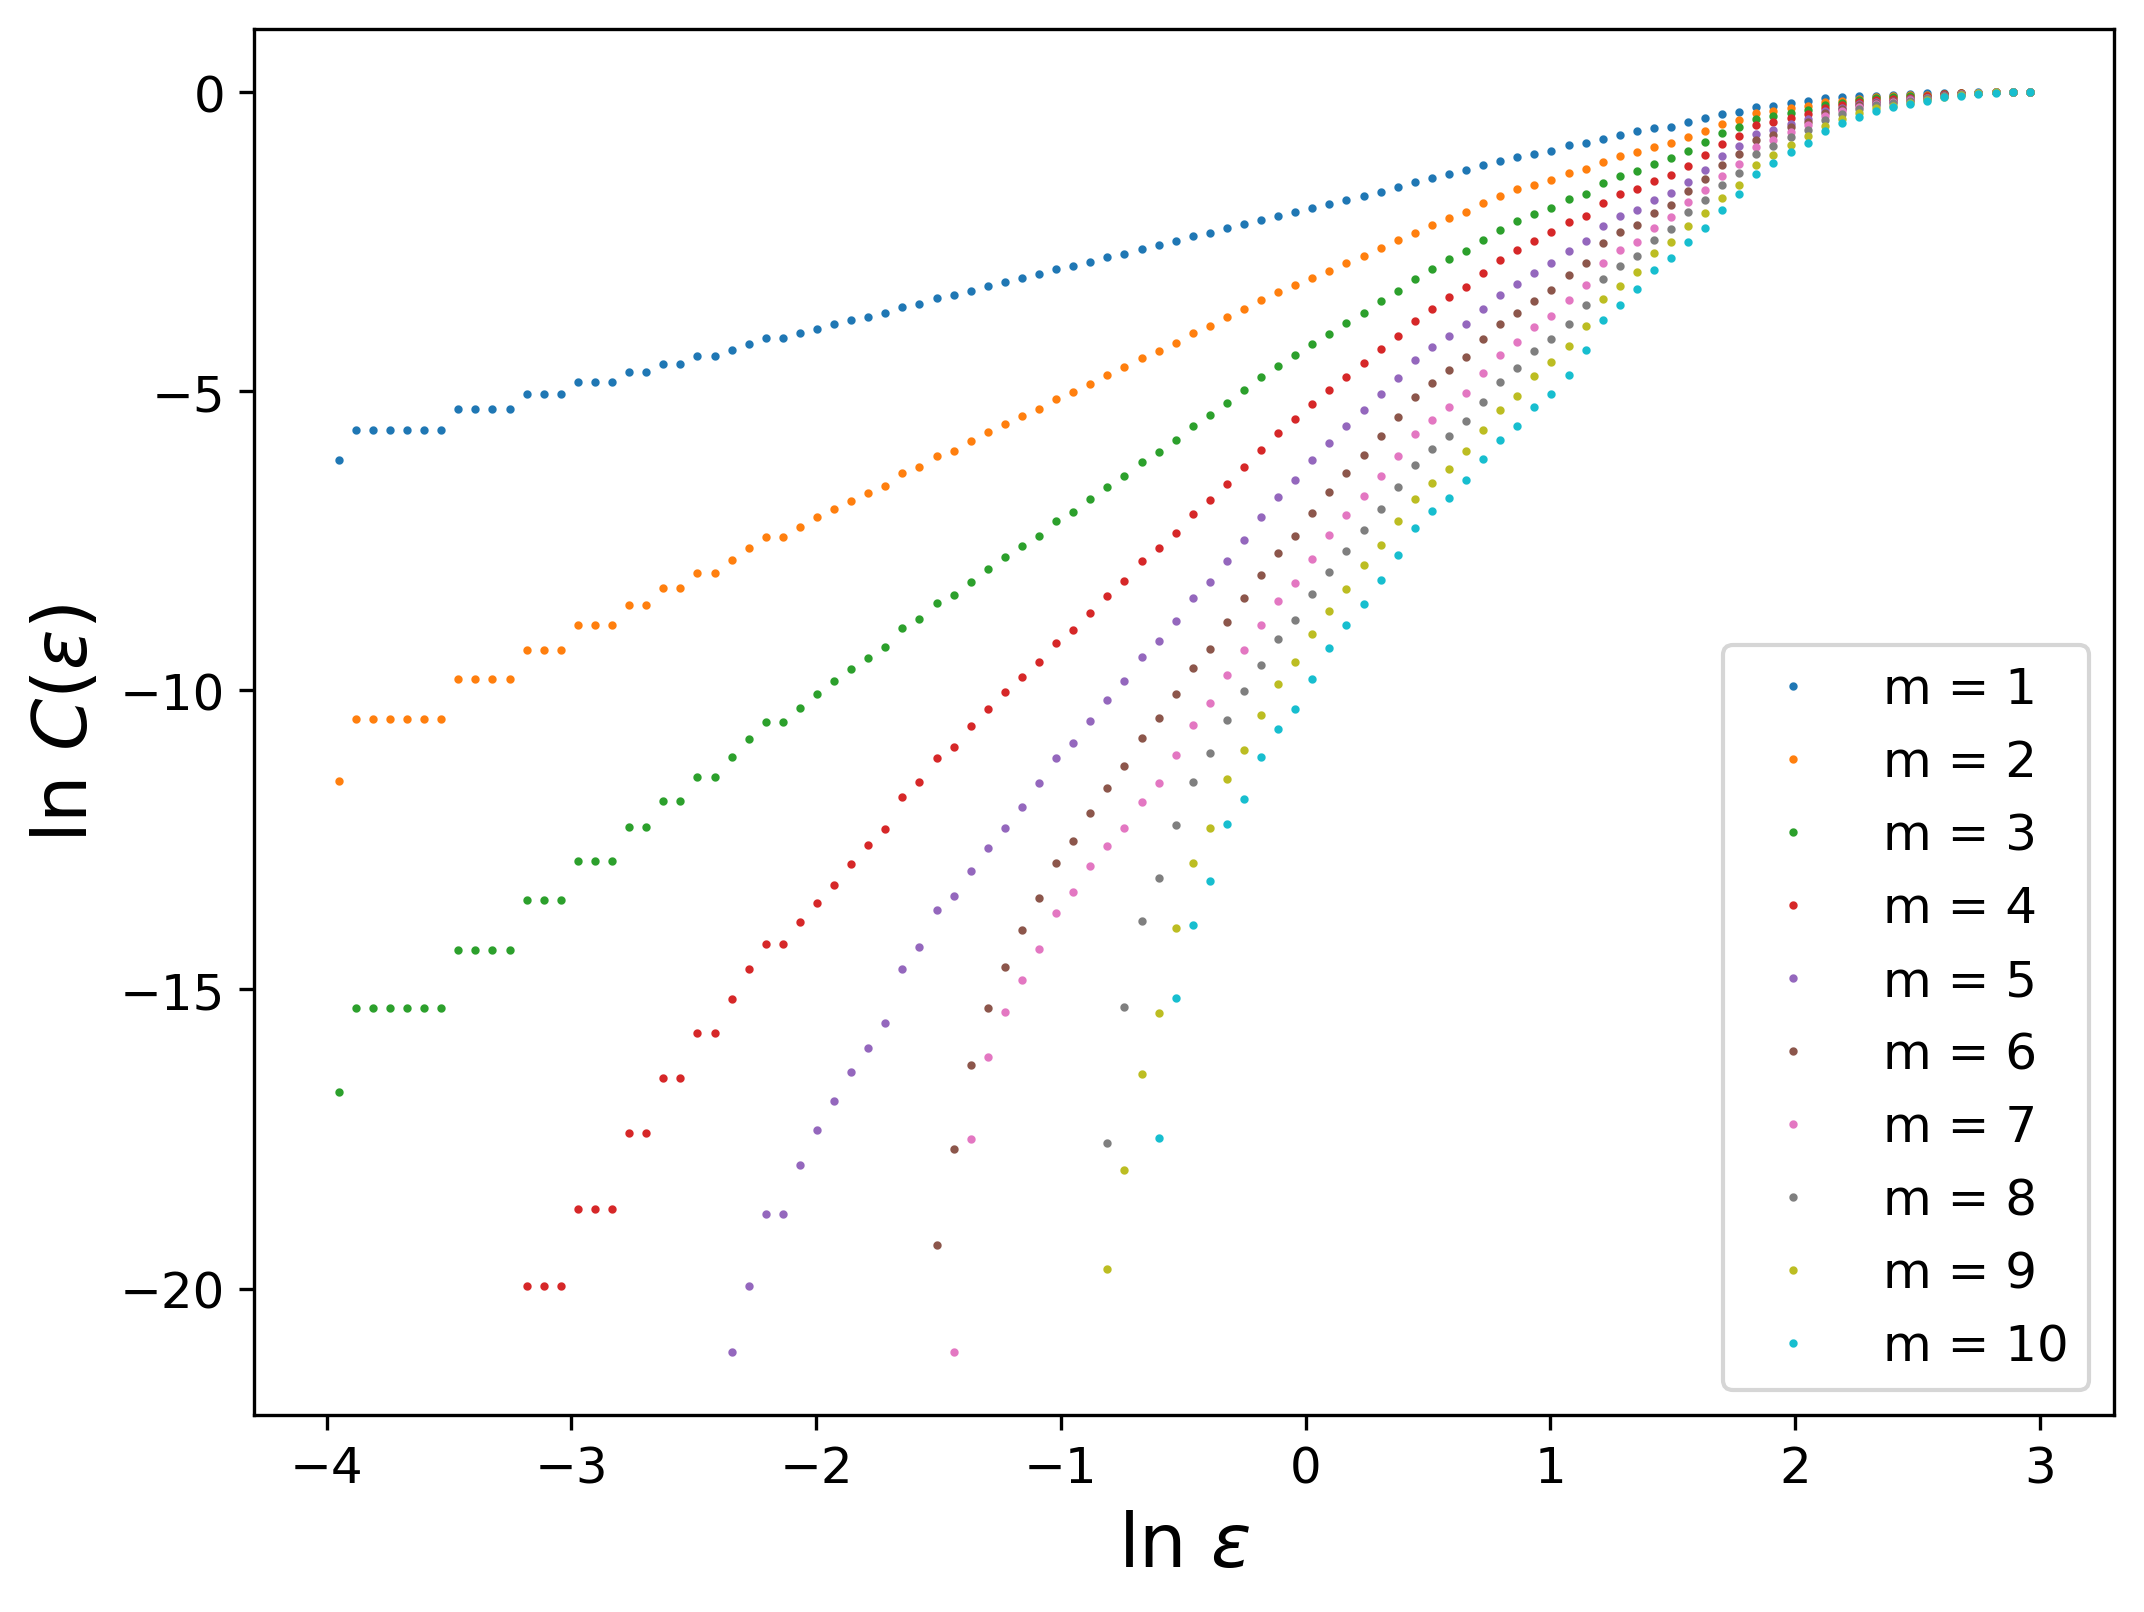

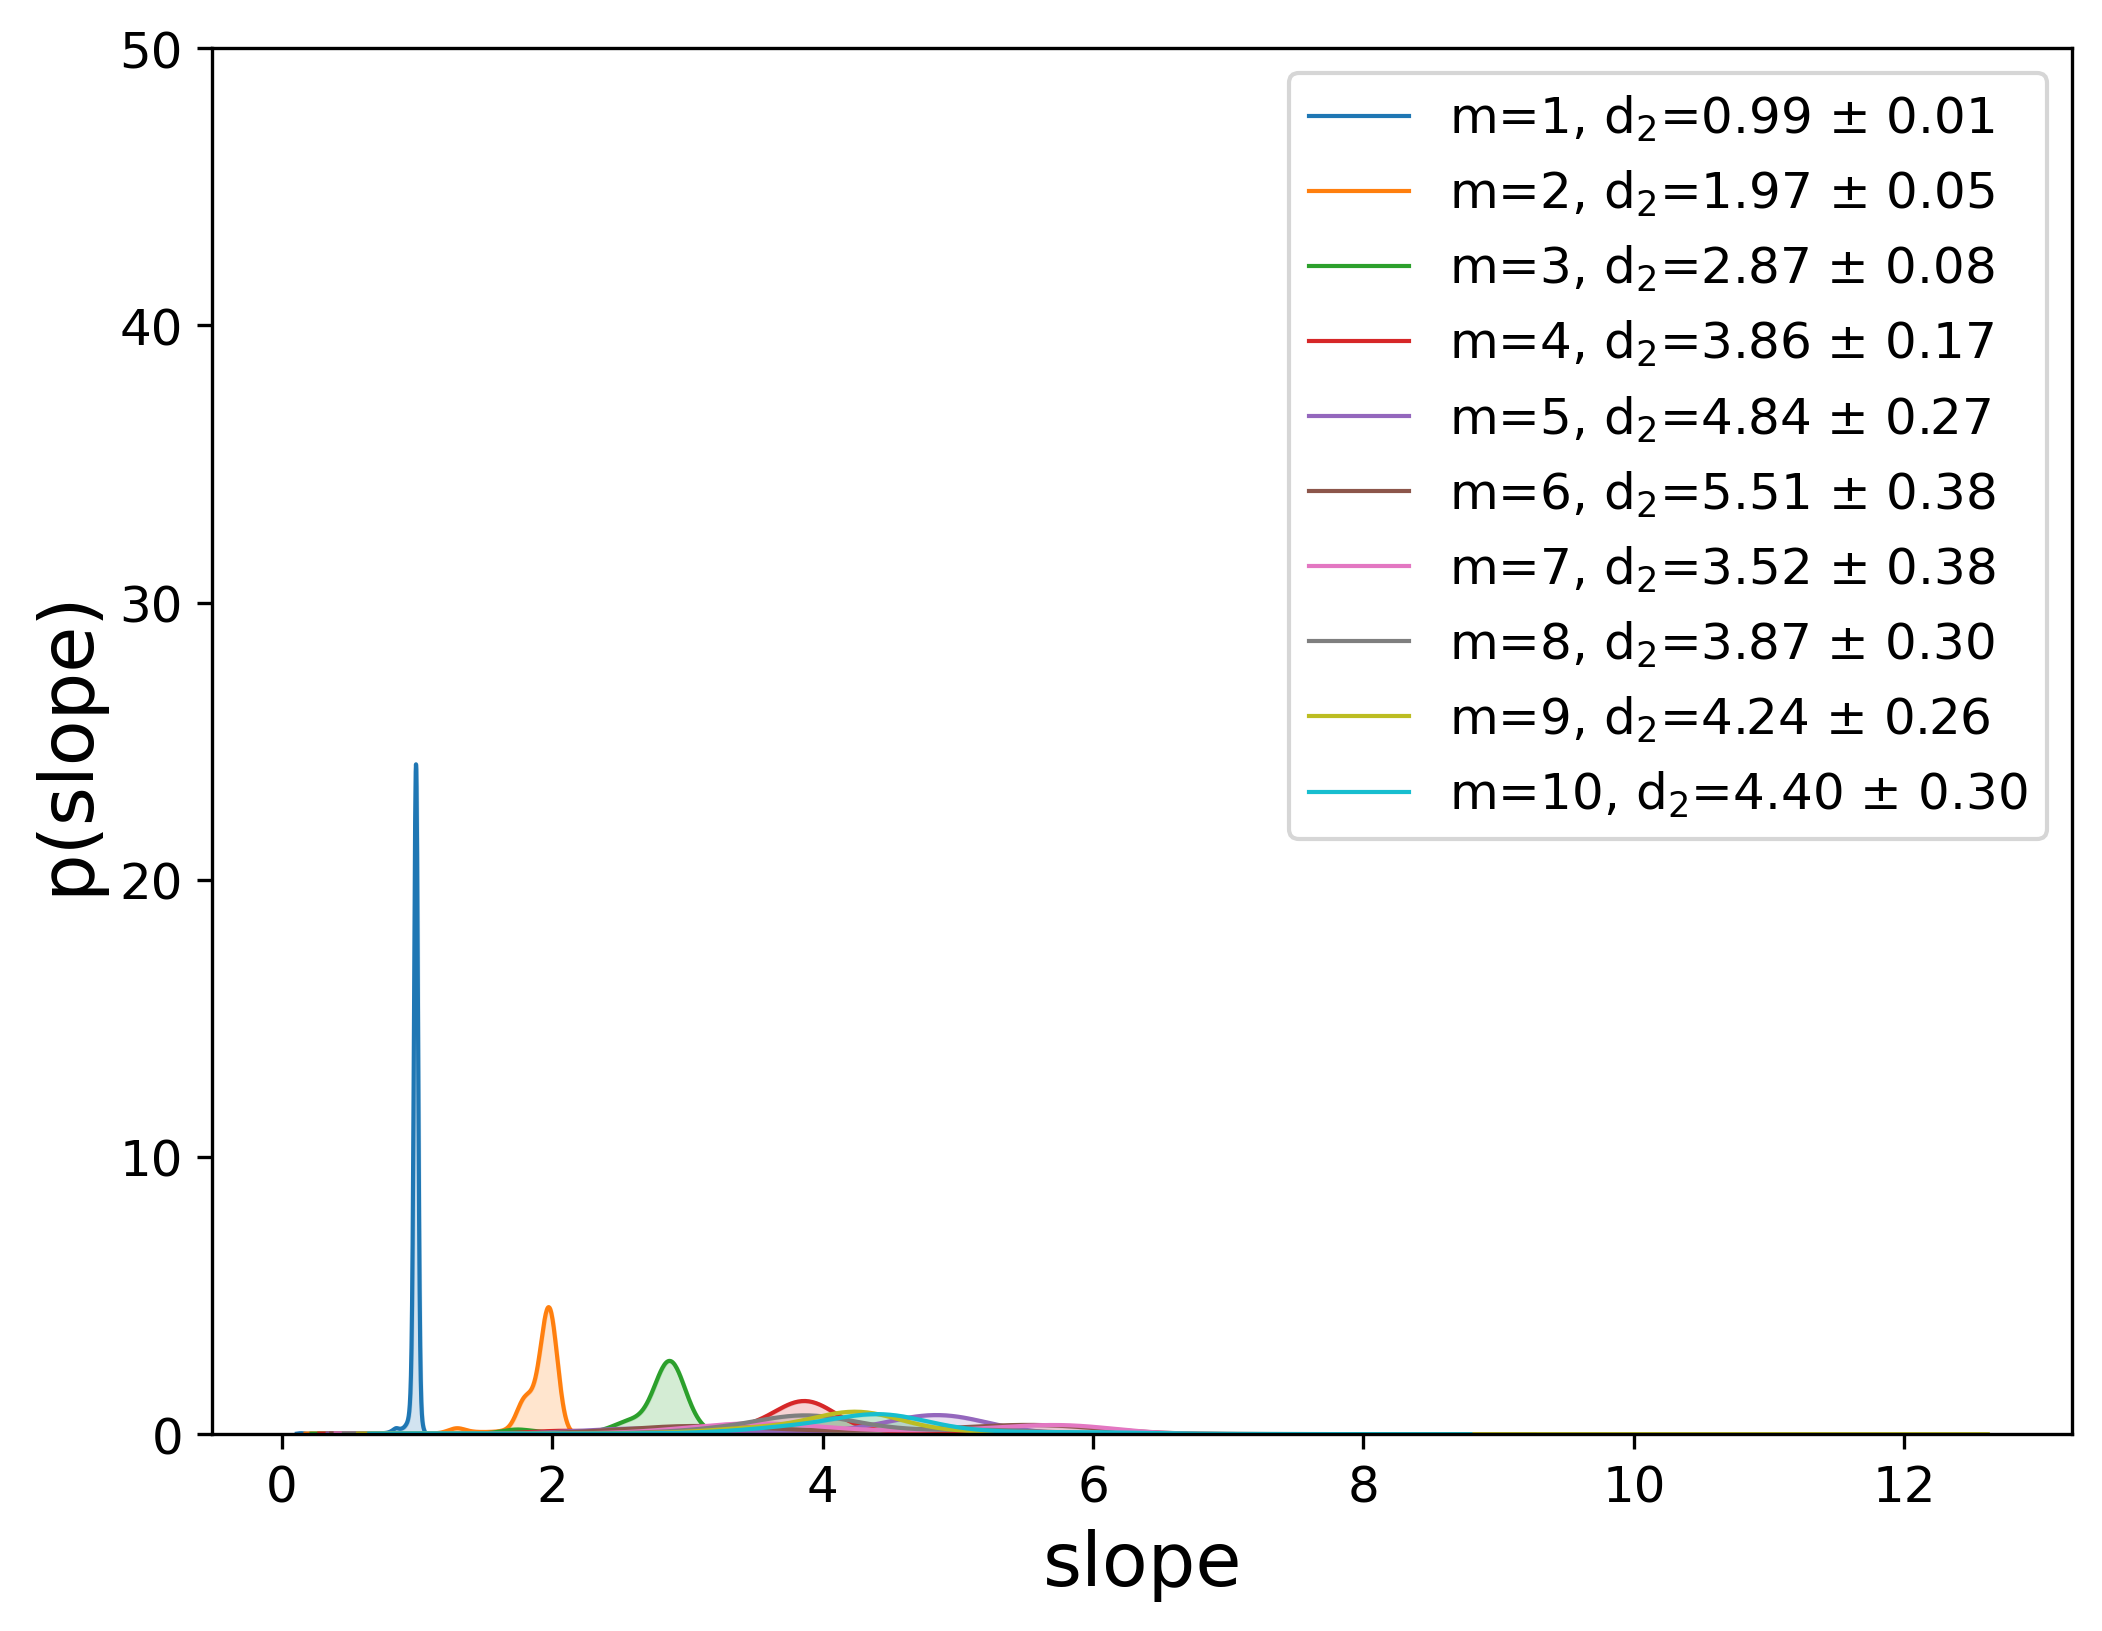

In [17]:
tau = 200
dims = 10
data_per_dim = 100

c2 = np.loadtxt('/content/deeperWAIS.dat.c2')
c2 = np.log(c2)

plt.figure(figsize=(8,6), dpi=300)
dim_range = np.arange(0,dims)

for dim_choice in dim_range:
    region = c2[dim_choice*data_per_dim:(dim_choice+1)*data_per_dim,:]
    plt.plot(region[:,0], region[:,1], '.', ms=2, label='m = {}'.format(dim_choice+1))

plt.xlabel(r'ln $\epsilon$', fontsize=18)
plt.ylabel(r'ln $C(\epsilon)$', fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(prop={'size': 12})
plt.savefig(output_dir + '/deeperWAIS_{}_d2.png'.format(tau))

plt.figure(figsize=(8,6), dpi=300)

KS_vals = []
th_vals = []
first_slope = True

for dim_choice in dim_range:
    region = c2[dim_choice*data_per_dim:(dim_choice+1)*data_per_dim,:]
    region = (region[~np.isinf(region[:,1])])
    bounds = [region[-1,0], region[0,0]]
    [lhs_arr, rhs_arr, slope, error, weights] = generate_individual_ensembles_ordered_fixed(region, bounds, 1, 2)
    kernel = gaussian_kde(slope, weights=weights)
    positions = np.linspace(np.min(slope), np.max(slope), num=500)
    lower_x, upper_x = half_max_x(positions,kernel(positions))
    mode = positions[np.argmax(kernel(positions))]
    fwhm = positions[np.where(np.logical_and(positions <= upper_x, positions >= lower_x))]
    error = np.std(positions[np.where(np.logical_and(positions <= upper_x, positions >= lower_x))])
    print("mode=", mode, "FWHM=",upper_x-lower_x, "prob=", np.sum(kernel(fwhm)) / np.sum(kernel(positions)), "error=",error)

    p = plt.plot(positions, kernel(positions), label=r'm=%d, d$_2$=%.2f $\pm$ %.2f' % (dim_choice+1,
                                                                             positions[np.argmax(kernel(positions))],error), lw=1)
    color = p[0].get_color()
    plt.fill_between(positions, kernel(positions), color=color, alpha=.2)
    slope_samples = slope

    if not first_slope:
        #KS = ks_2samp(slope_samples, slope_prev)[0]
        WD_res = WD(slope_samples, slope_prev, weights, weights_prev)
        KS_vals.append(WD_res)

    slope_prev = slope_samples
    weights_prev = weights
    first_slope = False

plt.xlabel(r'slope', fontsize=18)
plt.ylabel(r'p(slope)', fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.xlim((0.75,2.5))
plt.ylim((0,50))
#plt.title(r"$\tau = %d$ d$_2$ = %.2f" % (tau , positions[np.argmax(kernel(positions))]))
plt.legend(prop={'size': 12})
plt.savefig(output_dir + '/lorenz_reconstruction_{}_pdf.png'.format(tau))

print(KS_vals)

## Plot the Wasserstein profile. We assign a threshold of 0.1 for convergence. We see a convergence at m = 4 for this example.

[np.float64(0.9019982001173368), np.float64(0.8409363822307958), np.float64(0.8845469647196937), np.float64(0.7197608558781963), np.float64(0.521135838970568), np.float64(0.23444269408475013), np.float64(0.49363187495613436), np.float64(0.2595481670073693), np.float64(0.20234140894685304)]


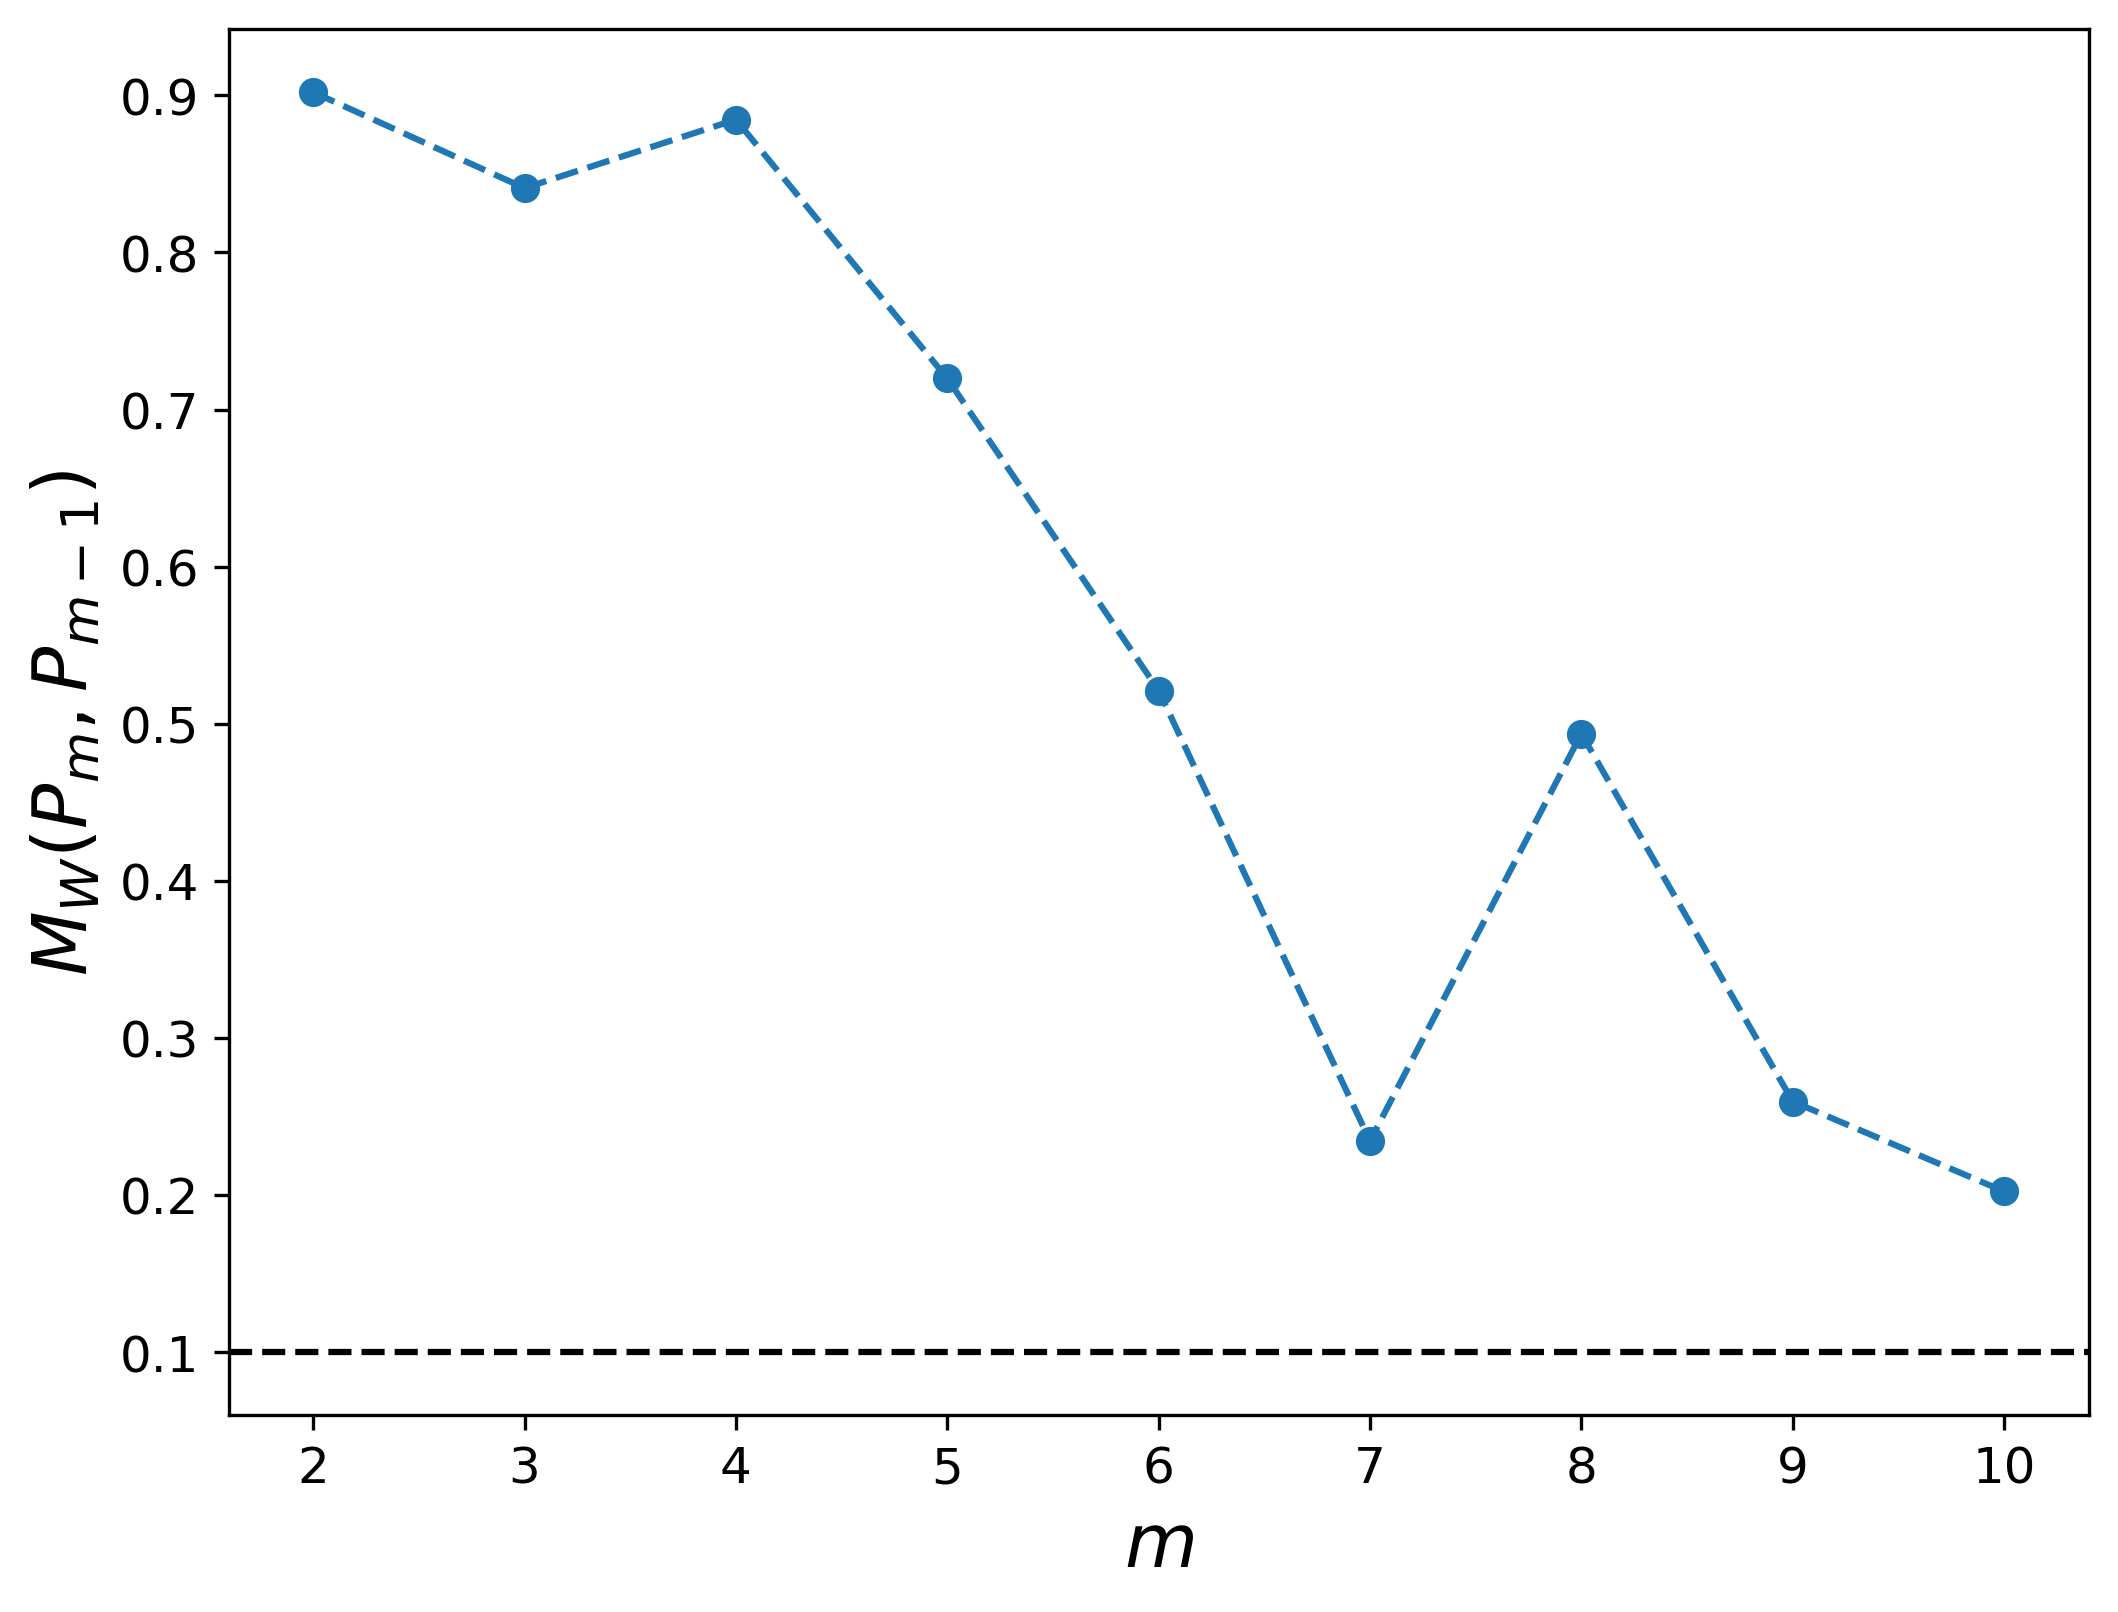

In [18]:
print(KS_vals)
plt.figure(figsize=(8,6), dpi=300)
plt.plot(dim_range[1:]+1, KS_vals, linestyle='--', marker='o')
plt.ylabel('$M_W(P_m, P_{m-1})$', fontsize=18)
plt.xlabel('$m$', fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.axhline(y=0.1, color='black', linestyle='--')
plt.savefig(output_dir + '/deeperWAIS_WD.png')